In [12]:
from collections import defaultdict
import numpy as np
import geopandas as gpd
import contextily as cx
from PIL import Image

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = [12, 15]

In [13]:
#Maps 
tiles_esri = "/Users/tamiratatsemegiorgis/project/MapTilesViewer/esri/{z}/{x}/{y}.png"
tiles_orthos ="/Users/tamiratatsemegiorgis/project/MapTilesViewer/orthos/{z}/{x}/{y}.png"
tiles_basic ="/Users/tamiratatsemegiorgis/project/MapTilesViewer/basic/{z}/{x}/{y}.png"

Load ASS points

In [14]:
source = gpd.read_file("data/GTK_ASsoil_obs.csv")
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))

points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")

In [15]:
points

CLASS                   geometry
0         ASS  POINT (25.76894 64.77799)
1         ASS  POINT (25.77630 64.79350)
2         ASS  POINT (25.78469 64.78681)
3         ASS  POINT (25.31512 64.98873)
4         ASS  POINT (25.34464 64.79449)
...       ...                        ...
5819      ASS  POINT (25.50228 65.64123)
5820  non-ASS  POINT (25.37067 65.62436)
5821  non-ASS  POINT (25.37108 65.62473)
5822      ASS  POINT (25.34070 65.58217)
5823      ASS  POINT (25.15943 65.62658)

[5824 rows x 2 columns]

In [16]:
points.to_csv('out.csv', index=False) 

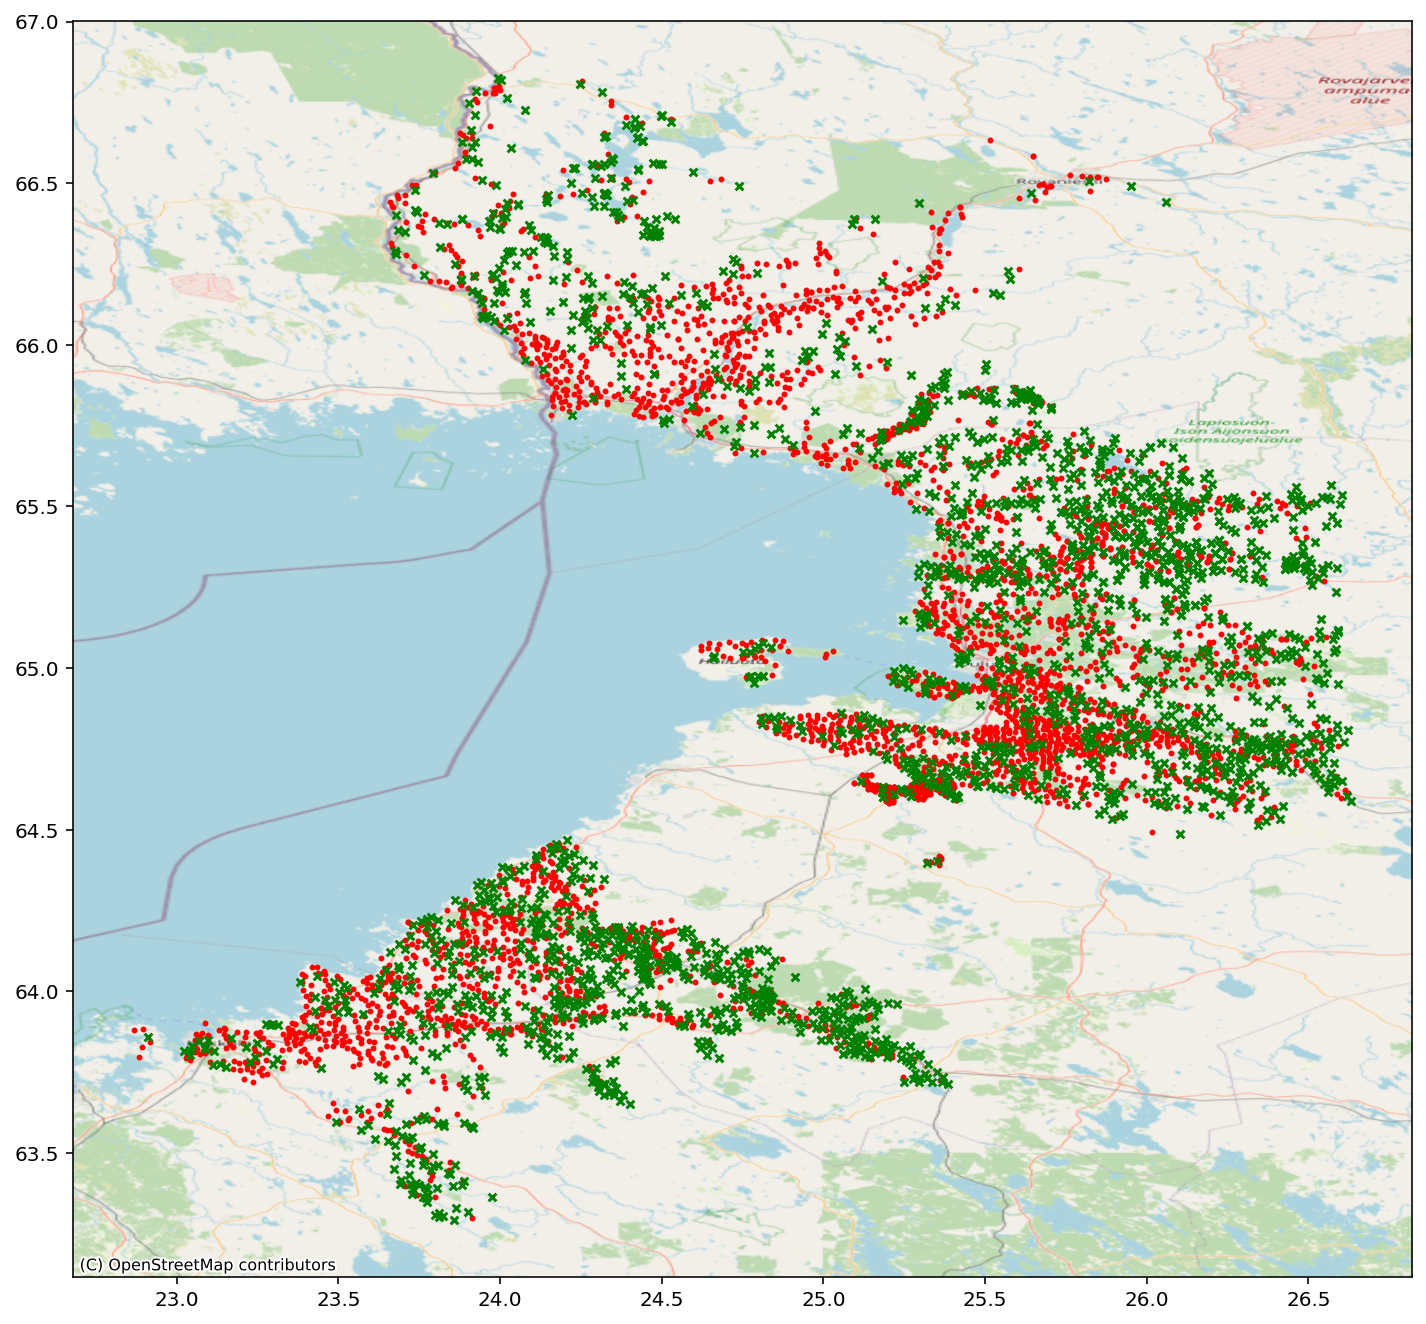

In [17]:
# CRS = "EPSG:3067"  # undisturbed view
CRS = "WGS84" #Web Mercator
pplot = points.to_crs(CRS)

base = pplot[pplot["CLASS"] == "ASS"].plot(c="r", marker='.', markersize=15)
pplot[pplot["CLASS"] != "ASS"].plot(ax=base, c="g", marker='x', markersize=15)

cx.add_basemap(base,crs=CRS, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)

In [18]:
TILE_SIZE = 256
def project(p, zoom=6):
    lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return (int(zoom), int(tx), int(ty)), (px, py)

In [19]:
points_per_tile = defaultdict(list)

for idx, p in points.iterrows():
    for z in range(3, 20):
        tile, (px, py) = project(p, zoom=z)
        points_per_tile[tile].append((px, py, p.CLASS))

In [20]:

def display_pixel(p, zoom, tileset):
    
    (tz, tx, ty), (px, py) = project(p, zoom=zoom)
    fname = tileset.format(z=tz, x=tx, y=ty)
    im = Image.open(fname)    
    plt.imshow(im, interpolation="lanczos")
        
    # print other points
    for (px1, py1, c) in points_per_tile[(tz, tx, ty)]:
        if px1 == px and py1 == py:
            # print point
            plt.plot(px, py, "o", c="w", markersize=25)
            plt.plot(px, py, "*", c="g" if c != "ASS" else "r", markersize=11)
        else:
            plt.plot(px1, py1, "*", c="w" if c != "ASS" else "r", markersize=11)
        
    
    plt.show()

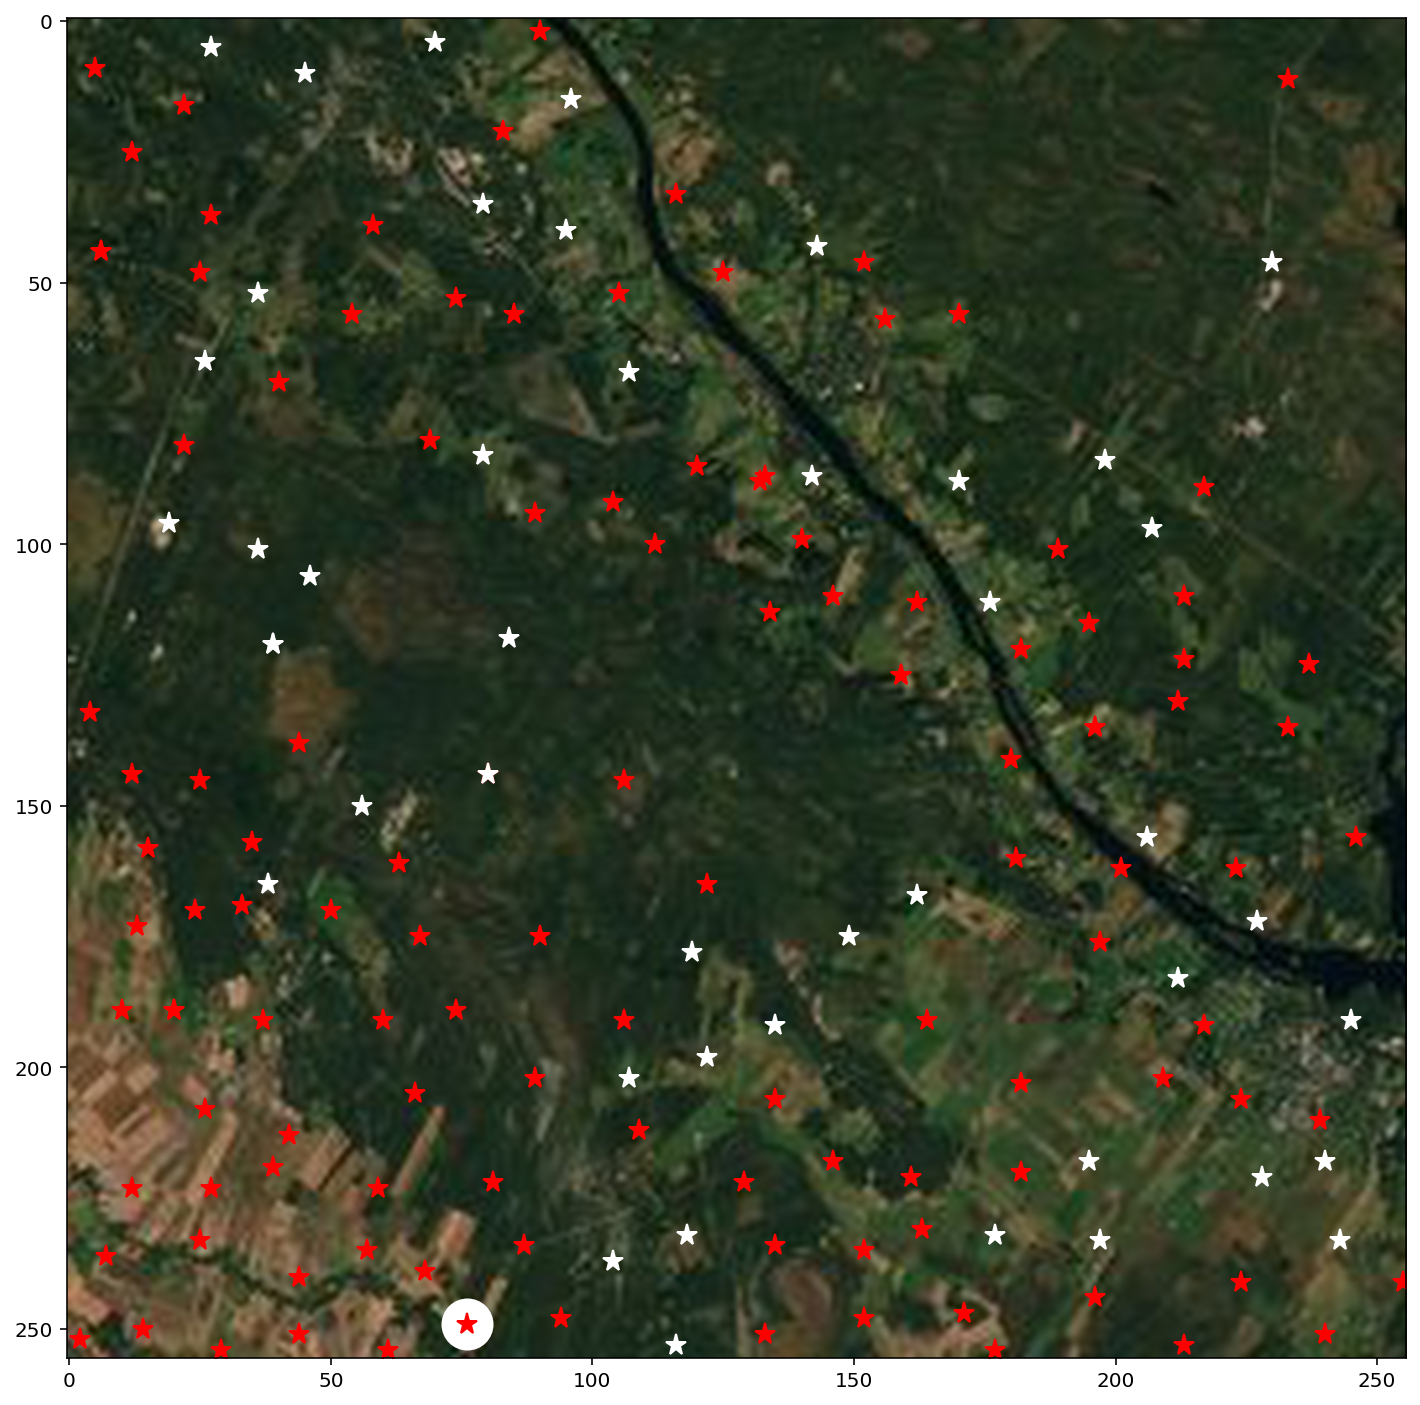

In [21]:
display_pixel(points.iloc[0], 10, tiles_esri)

In [22]:
points.CLASS.unique()

array(['ASS', 'non-ASS'], dtype=object)

In [23]:
#Create a datasets
def load_map(points, tiles, zoom_level):
    RGB_list=[]
    points_tiles_list=[]
    i=0
    for idx, p in points.iterrows():
        
        #for z in range(3, 20):
        (z, tx, ty), (px, py) = project(p, zoom=zoom_level)
        
        fname = tiles.format(z=z, x=tx, y=ty)
        im = Image.open(fname)    
        arr_img= np.array(im)
        
        Red,Green,Blue=arr_img[int(px),int(py)]
    
        
        points_tiles_list.append({"z": z, "tile_x": tx, "tile_y": ty, "x": px, "y": py, "class": points.loc[i].CLASS})
        RGB_list.append({"R":Red,"G":Green, "B":Blue, "CLASS":points.loc[i].CLASS})
        i=i+1
    df_points_tiles=gpd.GeoDataFrame(points_tiles_list)
    df_coor_points=df_points_tiles[['x','y','class']]
    df_RGB=gpd.GeoDataFrame(RGB_list)
    #return np.array(df_coor_points['x']), np.array(df_coor_points['y'])
    return df_RGB,df_coor_points


In [24]:
points.loc[0]

CLASS                                                ASS
geometry    POINT (25.768937832725747 64.77798766173387)
Name: 0, dtype: object

In [25]:
df_basic,_=load_map(points, tiles_basic, 10)


In [36]:
df_basic.head(4)


R   G   B CLASS
0  106  92  66   ASS
1   70  81  47   ASS
2   80  87  56   ASS
3   60  79  51   ASS

In [67]:
df_basic.groupby('CLASS').count()

R     G     B
CLASS                    
ASS      3490  3490  3490
non-ASS  2334  2334  2334

In [22]:
df_esri,_=load_map(points, tiles_esri, 10)


In [68]:
df_esri.head(4)


R   G   B CLASS
0  43  52  33   ASS
1  48  56  35   ASS
2  26  45  23   ASS
3  44  55  39   ASS

In [69]:
df_orthos,_=load_map(points, tiles_orthos, 10)


In [71]:
df_orthos.head(4)


R    G   B CLASS
0  82  101  71   ASS
1  81  103  67   ASS
2  71   90  60   ASS
3  61   85  53   ASS

In [77]:
import pandas as pd
df_merge=pd.merge(df_basic,df_esri,how="outer", left_index=True, right_index=True)
df_merge.head(4)

R_x  G_x  B_x CLASS_x  R_y  G_y  B_y CLASS_y
0  106   92   66     ASS   43   52   33     ASS
1   70   81   47     ASS   48   56   35     ASS
2   80   87   56     ASS   26   45   23     ASS
3   60   79   51     ASS   44   55   39     ASS

In [78]:
df_merge=df_merge.rename(columns={"R_x": "base_R", "G_x": "base_G", "B_x": "base_B", "R_y": "esri_R", 
                                  "G_y": "esri_G", "B_y": "esri_b", "CLASS_y": "CLASS"}).drop("CLASS_x", axis=1)

df_merge.head(4)

base_R  base_G  base_B  esri_R  esri_G  esri_b CLASS
0     106      92      66      43      52      33   ASS
1      70      81      47      48      56      35   ASS
2      80      87      56      26      45      23   ASS
3      60      79      51      44      55      39   ASS

In [81]:
df_merge =pd.merge(df_merge,df_orthos,how="outer", left_index=True, right_index=True )
df_merge=df_merge.rename(columns={"CLASS_y": "CLASS", "R": "orthos_R","G": "orthos_G", "B": "orthos_B"}).drop("CLASS_x", axis=1)
df_merge.head(4)


base_R  base_G  base_B  esri_R  esri_G  esri_b  orthos_R  orthos_G  \
0     106      92      66      43      52      33        82       101   
1      70      81      47      48      56      35        81       103   
2      80      87      56      26      45      23        71        90   
3      60      79      51      44      55      39        61        85   

   orthos_B CLASS  
0        71   ASS  
1        67   ASS  
2        60   ASS  
3        53   ASS

In [82]:
len(df_merge)

5824

In [83]:

df_merge.describe()

base_R       base_G       base_B       esri_R       esri_G  \
count  5824.000000  5824.000000  5824.000000  5824.000000  5824.000000   
mean     39.064217    38.204327    50.299794    41.450378    54.034169   
std      75.215863    83.385421    54.634182    21.394794    18.190513   
min    -128.000000  -128.000000  -128.000000  -128.000000  -125.000000   
25%      20.750000    15.750000    37.000000    30.000000    45.000000   
50%      65.000000    73.000000    59.000000    38.000000    52.000000   
75%      92.000000    99.000000    83.000000    50.000000    62.000000   
max     127.000000   127.000000   127.000000   127.000000   127.000000   

            esri_b     orthos_R     orthos_G     orthos_B  
count  5824.000000  5824.000000  5824.000000  5824.000000  
mean     33.992788    63.444025    69.003091    69.473214  
std      13.206218    54.179014    70.588748    39.928353  
min    -113.000000  -128.000000  -128.000000  -128.000000  
25%      26.000000    63.000000    81.000000    62.000000  
50%      32.000000    75.000000    92.000000    72.000000  
75%      39.000000    89.000000   104.000000    87.000000  
max     123.000000   127.000000   127.000000   127.000000

In [97]:
#change catagorical variables to numerical "ASS" to 1 and "non-ASS" to 0
replace_list = {"CLASS": {"ASS": 1, "non-ASS": 0 }}
df_merge.replace(replace_list, inplace=True)

In [132]:
df_merge.CLASS.value_counts()

1    3490
0    2334
Name: CLASS, dtype: int64

In [244]:
df_merge.head(4)

base_R  base_G  base_B  esri_R  esri_G  esri_b  orthos_R  orthos_G  \
0     106      92      66      43      52      33        82       101   
1      70      81      47      48      56      35        81       103   
2      80      87      56      26      45      23        71        90   
3      60      79      51      44      55      39        61        85   

   orthos_B  CLASS  
0        71      1  
1        67      1  
2        60      1  
3        53      1

In [135]:
# turn into numpy arrays
X = df_merge.iloc[:,0:9].values  # dependent features
y = df_merge['CLASS'].values   # target

In [141]:
X

array([[ 106,   92,   66, ...,   82,  101,   71],
       [  70,   81,   47, ...,   81,  103,   67],
       [  80,   87,   56, ...,   71,   90,   60],
       ...,
       [  87,   98,   64, ...,   89,  103,   80],
       [ -78,  -74, -111, ...,  -95,  -81, -104],
       [   9,   38,   52, ...,   16,   72,   99]], dtype=int8)

In [142]:
y

array([1, 1, 1, ..., 0, 1, 1])

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [144]:
len(X_train)

3902

In [145]:
Ranmf = RandomForestClassifier(max_depth=2, random_state=0)
Ranmf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [146]:
GradBoost = GradientBoostingClassifier(learning_rate=0.01,random_state=0)
GradBoost.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [147]:
print(" GradBoost test score is: {:.2}".format(GradBoost.score(X_test, y_test)))
print(" GradBoost training  score is: {:.2}".format(GradBoost.score(X_train, y_train)))

 GradBoost test score is: 0.61
 GradBoost training  score is: 0.6


In [150]:
print("test score is: {:.2}".format(Ranmf.score(X_test, y_test)))
print("training  score is: {:.2}".format(Ranmf.score(X_train, y_train)))

test score is: 0.61
training  score is: 0.6


In [153]:
Ranmf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [152]:
y_test

array([0, 1, 1, ..., 1, 0, 0])